# Phase 1: Looking Inside GPT-2

**Goal:** Develop an intuitive, hands-on understanding of transformer internals — not from reading about them, but from poking at a real model.

We'll use **GPT-2 Small** (124M parameters, 12 layers, 12 attention heads per layer, 768-dimensional residual stream) — the "fruit fly" of mech interp.

By the end of this notebook you'll be able to:
1. Load a model and access any internal activation
2. Understand the residual stream as the model's "shared memory"
3. Visualize what attention heads are actually doing
4. See how the model's prediction evolves layer by layer (logit lens)
5. Do your first causal intervention (what breaks if we remove a component?)

## Setup

In [2]:
import torch
import transformer_lens as tl
from transformer_lens import HookedTransformer, utils
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from einops import rearrange, reduce, repeat
import importlib.metadata

# Check device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
print(f"TransformerLens version: {importlib.metadata.version('transformer-lens')}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
TransformerLens version: 2.17.0
PyTorch version: 2.10.0


## 1. Load GPT-2 Small

TransformerLens wraps the model so every internal activation is accessible. First download will take a moment, then it's cached.

In [3]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device, dtype=torch.float32)

print(f"Model: {model.cfg.model_name}")
print(f"Layers: {model.cfg.n_layers}")
print(f"Attention heads per layer: {model.cfg.n_heads}")
print(f"Hidden dimension (residual stream): {model.cfg.d_model}")
print(f"MLP hidden dimension: {model.cfg.d_mlp}")
print(f"Vocabulary size: {model.cfg.d_vocab}")
print(f"Context length: {model.cfg.n_ctx}")
print(f"Head dimension: {model.cfg.d_head}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Model: gpt2
Layers: 12
Attention heads per layer: 12
Hidden dimension (residual stream): 768
MLP hidden dimension: 3072
Vocabulary size: 50257
Context length: 1024
Head dimension: 64

Total parameters: 163,049,041


### Key Architecture Numbers

```
GPT-2 Small
├── Embedding: token (50257 → 768) + position (1024 → 768)
├── 12 Transformer Blocks, each containing:
│   ├── Layer Norm
│   ├── Multi-Head Attention (12 heads, each 64-dim)
│   │   ├── Q, K, V projections: 768 → 12×64
│   │   └── Output projection: 12×64 → 768
│   ├── Layer Norm
│   └── MLP
│       ├── Up projection: 768 → 3072
│       ├── GELU activation
│       └── Down projection: 3072 → 768
└── Unembedding: 768 → 50257

The residual stream (768-dim vector per token) flows through the entire network.
Every attention head and MLP READS from it and WRITES back to it.
```

## 2. The Residual Stream — Shared Memory

The key insight from [Elhage et al. 2021](https://transformer-circuits.pub/2021/framework/index.html):

> A transformer is not a sequence of layers that transform activations. It's a **residual stream** that components read from and write to.

Every component (attention head, MLP) **adds** to the residual stream. The final residual stream is what gets turned into the next-token prediction.

Let's actually see it.

In [4]:
# Run a prompt through the model, caching ALL internal activations
prompt = "The capital of France is"
tokens = model.to_tokens(prompt, prepend_bos=False)
print(f"Tokens: {[model.to_string(t) for t in tokens[0]]}")
print(f"Token IDs: {tokens[0].tolist()}")
print(f"Shape: {tokens.shape} (batch=1, seq_len={tokens.shape[1]})")

Tokens: ['The', ' capital', ' of', ' France', ' is']
Token IDs: [464, 3139, 286, 4881, 318]
Shape: torch.Size([1, 5]) (batch=1, seq_len=5)


In [5]:
# Run with cache — this stores EVERY internal activation
logits, cache = model.run_with_cache(tokens)

print(f"Output logits shape: {logits.shape}")
print(f"  → (batch={logits.shape[0]}, seq_len={logits.shape[1]}, vocab={logits.shape[2]})")
print(f"\nCached activations: {len(cache)} tensors")
print(f"\nSome cache keys:")
for key in sorted(cache.keys())[:15]:
    print(f"  {key}: {cache[key].shape}")

Output logits shape: torch.Size([1, 5, 50257])
  → (batch=1, seq_len=5, vocab=50257)

Cached activations: 208 tensors

Some cache keys:
  blocks.0.attn.hook_attn_scores: torch.Size([1, 12, 5, 5])
  blocks.0.attn.hook_k: torch.Size([1, 5, 12, 64])
  blocks.0.attn.hook_pattern: torch.Size([1, 12, 5, 5])
  blocks.0.attn.hook_q: torch.Size([1, 5, 12, 64])
  blocks.0.attn.hook_v: torch.Size([1, 5, 12, 64])
  blocks.0.attn.hook_z: torch.Size([1, 5, 12, 64])
  blocks.0.hook_attn_out: torch.Size([1, 5, 768])
  blocks.0.hook_mlp_out: torch.Size([1, 5, 768])
  blocks.0.hook_resid_mid: torch.Size([1, 5, 768])
  blocks.0.hook_resid_post: torch.Size([1, 5, 768])
  blocks.0.hook_resid_pre: torch.Size([1, 5, 768])
  blocks.0.ln1.hook_normalized: torch.Size([1, 5, 768])
  blocks.0.ln1.hook_scale: torch.Size([1, 5, 1])
  blocks.0.ln2.hook_normalized: torch.Size([1, 5, 768])
  blocks.0.ln2.hook_scale: torch.Size([1, 5, 1])


In [6]:
# The residual stream at each layer
# This is THE central data structure — the 768-dim vector per token, evolving through the network

# Get residual stream after each block
residual_streams = []
labels = []

# After embedding (layer 0 input)
residual_streams.append(cache["blocks.0.hook_resid_pre"])
labels.append("After Embed")

# After each layer
for layer in range(model.cfg.n_layers):
    residual_streams.append(cache[f"blocks.{layer}.hook_resid_post"])
    labels.append(f"After Layer {layer}")

# Stack and look at the last token position (the prediction position)
all_resid = torch.stack(residual_streams)[:, 0, -1, :]  # [layers, d_model]
print(f"Residual stream evolution: {all_resid.shape}")
print(f"  → {all_resid.shape[0]} snapshots, each {all_resid.shape[1]}-dimensional")

Residual stream evolution: torch.Size([13, 768])
  → 13 snapshots, each 768-dimensional


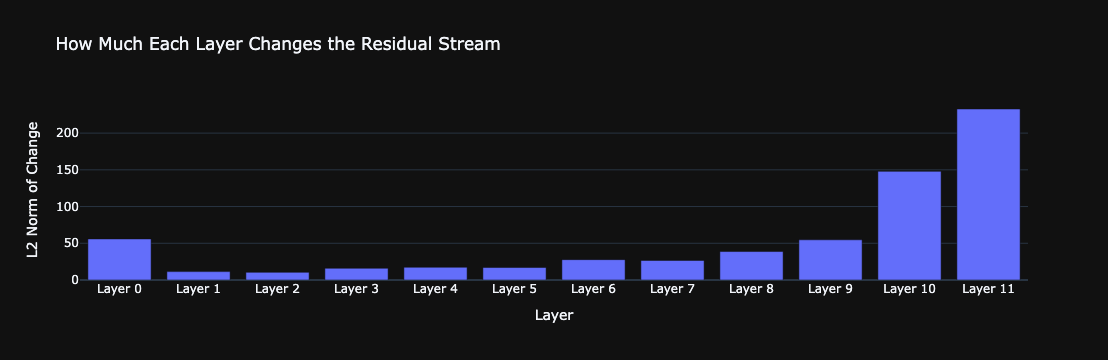

In [7]:
# Visualize: how much does each layer change the residual stream?
norms = []
for i in range(1, len(all_resid)):
    delta = all_resid[i] - all_resid[i-1]
    norms.append(delta.norm().item())

fig = px.bar(
    x=[f"Layer {i}" for i in range(12)],
    y=norms,
    title="How Much Each Layer Changes the Residual Stream",
    labels={"x": "Layer", "y": "L2 Norm of Change"},
    template="plotly_dark"
)
fig.update_layout(showlegend=False)
fig.show()

### What Are Attention vs MLPs Contributing?

Each layer has two components that write to the residual stream:
1. **Attention** — moves information between token positions
2. **MLP** — processes information at each position

Let's see which one matters more at each layer.

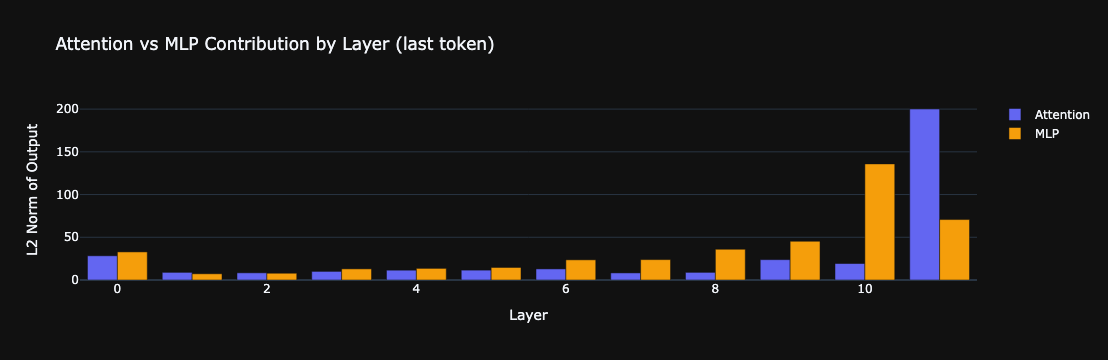

In [8]:
# Compare attention vs MLP contributions at the last token
attn_norms = []
mlp_norms = []

for layer in range(model.cfg.n_layers):
    attn_out = cache[f"blocks.{layer}.hook_attn_out"][0, -1, :]
    mlp_out = cache[f"blocks.{layer}.hook_mlp_out"][0, -1, :]
    attn_norms.append(attn_out.norm().item())
    mlp_norms.append(mlp_out.norm().item())

fig = go.Figure()
fig.add_trace(go.Bar(name="Attention", x=list(range(12)), y=attn_norms, marker_color="#6366f1"))
fig.add_trace(go.Bar(name="MLP", x=list(range(12)), y=mlp_norms, marker_color="#f59e0b"))
fig.update_layout(
    barmode="group",
    title="Attention vs MLP Contribution by Layer (last token)",
    xaxis_title="Layer",
    yaxis_title="L2 Norm of Output",
    template="plotly_dark"
)
fig.show()

## 3. Attention Heads — Information Routing

Each layer has 12 attention heads. Each head decides:
- **What to attend to** (QK circuit) — which earlier tokens are relevant?
- **What to move** (OV circuit) — what information to copy from those tokens?

Attention patterns tell us *where* each head is looking.

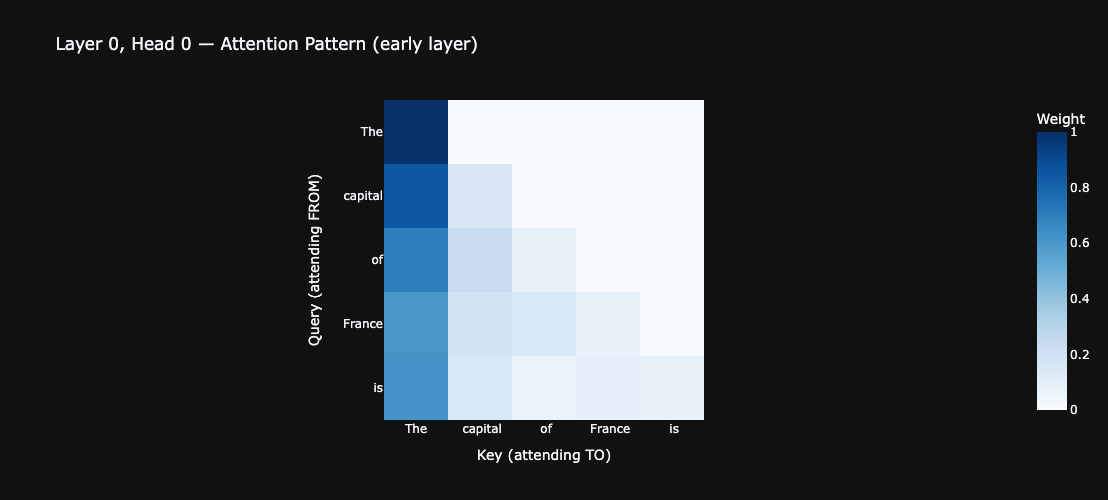

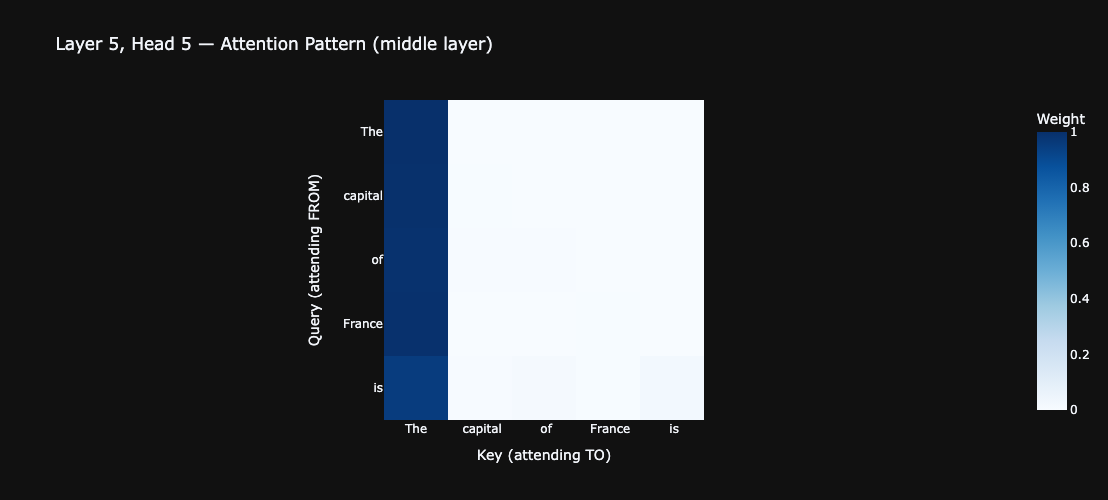

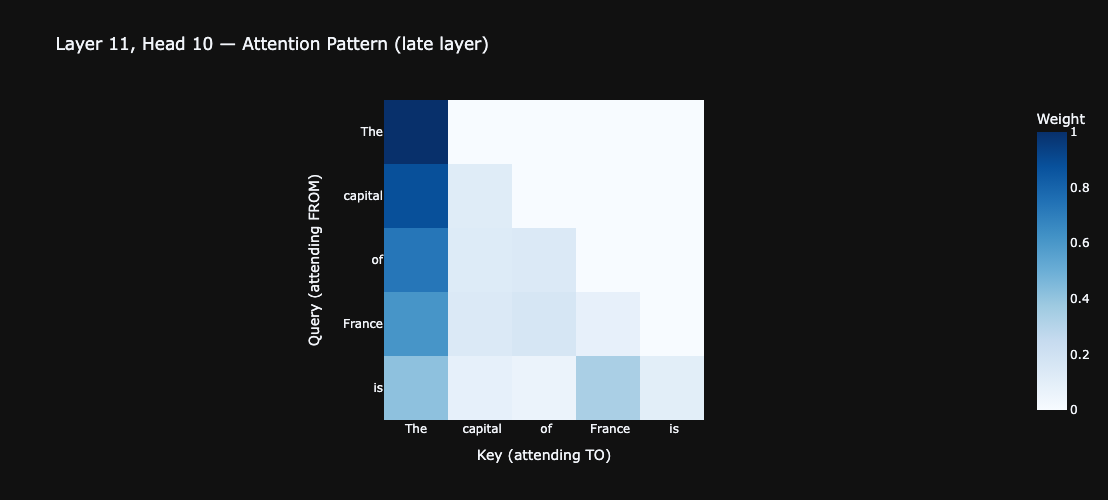

In [9]:
# Get all attention patterns
# Shape: [batch, n_heads, seq_len (query), seq_len (key)]

prompt = "The capital of France is"
tokens = model.to_tokens(prompt, prepend_bos=False)
token_labels = [model.to_string(t) for t in tokens[0]]

logits, cache = model.run_with_cache(tokens)

# Show attention patterns for a few interesting heads
def plot_attention(layer, head, title_extra=""):
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, head].detach().cpu().numpy()
    
    fig = px.imshow(
        pattern,
        x=token_labels,
        y=token_labels,
        color_continuous_scale="Blues",
        title=f"Layer {layer}, Head {head} — Attention Pattern {title_extra}",
        labels={"x": "Key (attending TO)", "y": "Query (attending FROM)", "color": "Weight"},
        template="plotly_dark"
    )
    fig.update_layout(width=500, height=500)
    fig.show()

# Plot a few heads
plot_attention(0, 0, "(early layer)")
plot_attention(5, 5, "(middle layer)")
plot_attention(11, 10, "(late layer)")

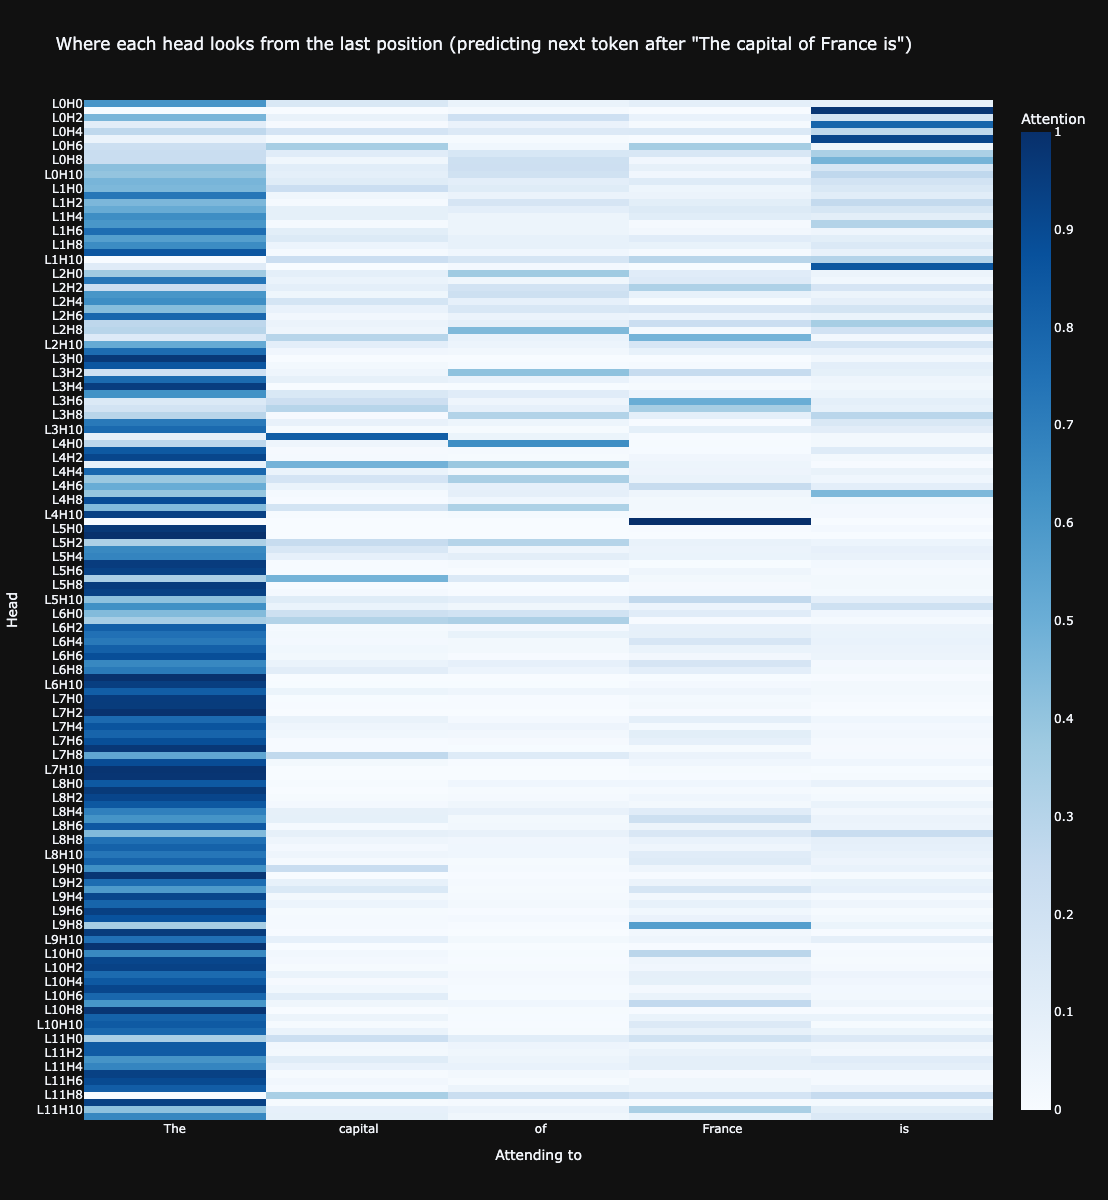

In [10]:
# Which heads attend most to the last token position?
# This tells us which heads are most involved in predicting the next token

last_token_attention = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, :, -1, :]  # [heads, key_pos]
    # What does the last query token attend to?
    last_token_attention[layer] = pattern.sum(dim=-1).detach().cpu()  # just checking it sums to 1
    # More interesting: where does the last token LOOK?
    last_token_attention[layer] = pattern[:, -1].detach().cpu()  # attention on self

# Better: for each head, what % of attention from last token goes to each position?
fig_data = []
for layer in range(model.cfg.n_layers):
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0, :, -1, :].detach().cpu()  # [heads, key_pos]
    for head in range(model.cfg.n_heads):
        for pos, tok in enumerate(token_labels):
            fig_data.append({
                "layer": layer, "head": head,
                "position": tok, "pos_idx": pos,
                "attention": pattern[head, pos].item()
            })

df = pd.DataFrame(fig_data)

# Heatmap: for each head, where does the LAST token attend?
pivot = df.pivot_table(index=["layer", "head"], columns="position", values="attention")
# Reorder columns by position
pivot = pivot[token_labels]

fig = px.imshow(
    pivot.values,
    x=token_labels,
    y=[f"L{l}H{h}" for l in range(12) for h in range(12)],
    color_continuous_scale="Blues",
    title=f'Where each head looks from the last position (predicting next token after "{prompt}")',
    labels={"x": "Attending to", "y": "Head", "color": "Attention"},
    template="plotly_dark",
    aspect="auto"
)
fig.update_layout(height=1200)
fig.show()

## 4. The Logit Lens — Watching the Model Think

The **logit lens** is a beautifully simple technique:
1. Take the residual stream at any intermediate layer
2. Apply the final unembedding matrix (normally only applied at the end)
3. See what the model would predict *at that point in processing*

This reveals how the model's "belief" evolves layer by layer. Often the model "knows" the answer well before the final layer.

In [11]:
# Logit lens: apply unembedding at each layer
prompt = "The capital of France is"
tokens = model.to_tokens(prompt, prepend_bos=False)
logits, cache = model.run_with_cache(tokens)

# Get the model's final prediction
final_probs = logits[0, -1].softmax(dim=-1)
top_k_final = torch.topk(final_probs, 5)
print("Final prediction (top 5):")
for i in range(5):
    token_str = model.to_string(top_k_final.indices[i].item())
    print(f"  {token_str!r}: {top_k_final.values[i].item():.3f}")

Final prediction (top 5):
  ' the': 0.085
  ' now': 0.048
  ' a': 0.046
  ' France': 0.032
  ' Paris': 0.032


In [12]:
# Now: what would the model predict at EACH layer?
# (logit lens = apply unembedding to intermediate residual streams)

# Track the top prediction and the correct answer's rank at each layer
correct_token = model.to_tokens(" Paris", prepend_bos=False)[0, 0]  # the token for " Paris"
print(f"Correct token: {model.to_string(correct_token)!r} (ID: {correct_token.item()})")

layer_predictions = []
paris_probs = []
paris_ranks = []

for layer in range(model.cfg.n_layers + 1):  # +1 for after embedding
    if layer == 0:
        resid = cache["blocks.0.hook_resid_pre"][0, -1]  # after embedding
    else:
        resid = cache[f"blocks.{layer-1}.hook_resid_post"][0, -1]  # after this layer
    
    # Apply layer norm + unembedding
    normed = model.ln_final(resid)
    layer_logits = model.unembed(normed.unsqueeze(0).unsqueeze(0))[0, 0]
    probs = layer_logits.softmax(dim=-1)
    
    # Top prediction
    top_token = layer_logits.argmax().item()
    top_prob = probs[top_token].item()
    
    # Where is "Paris"?
    paris_prob = probs[correct_token].item()
    paris_rank = (probs > paris_prob).sum().item() + 1
    
    layer_name = "Embed" if layer == 0 else f"Layer {layer-1}"
    top_str = model.to_string(top_token)
    layer_predictions.append({
        "layer": layer_name,
        "top_prediction": top_str,
        "top_prob": top_prob,
        "paris_prob": paris_prob,
        "paris_rank": paris_rank
    })
    paris_probs.append(paris_prob)
    paris_ranks.append(paris_rank)
    
    print(f"{layer_name:>10}: top={top_str!r:>12} ({top_prob:.3f}) | 'Paris' rank={paris_rank:>5}, prob={paris_prob:.4f}")

Correct token: ' Paris' (ID: 6342)
     Embed: top=   ' destro' (0.533) | 'Paris' rank=21416, prob=0.0000
   Layer 0: top=      ' not' (0.332) | 'Paris' rank=16524, prob=0.0000
   Layer 1: top=      ' now' (0.271) | 'Paris' rank=18483, prob=0.0000
   Layer 2: top=      ' now' (0.366) | 'Paris' rank=13624, prob=0.0000
   Layer 3: top=      ' now' (0.515) | 'Paris' rank= 8649, prob=0.0000
   Layer 4: top=      ' now' (0.627) | 'Paris' rank= 3106, prob=0.0000
   Layer 5: top=      ' now' (0.552) | 'Paris' rank= 3040, prob=0.0000
   Layer 6: top=      ' now' (0.572) | 'Paris' rank=  200, prob=0.0001
   Layer 7: top=      ' now' (0.689) | 'Paris' rank=  275, prob=0.0000
   Layer 8: top=      ' now' (0.423) | 'Paris' rank=   52, prob=0.0006
   Layer 9: top=   ' France' (0.621) | 'Paris' rank=    2, prob=0.1819
  Layer 10: top=   ' France' (0.242) | 'Paris' rank=    2, prob=0.1391
  Layer 11: top=      ' the' (0.085) | 'Paris' rank=    5, prob=0.0322


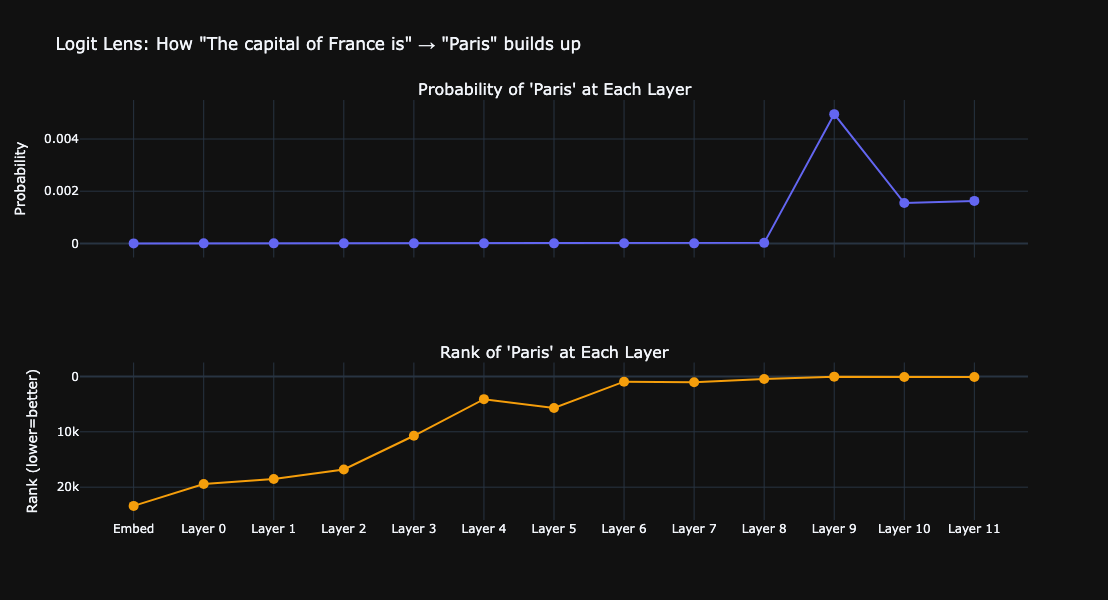

In [34]:
# Visualize the logit lens
layer_names = [d["layer"] for d in layer_predictions]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=["Probability of 'Paris' at Each Layer",
                                   "Rank of 'Paris' at Each Layer"])

fig.add_trace(
    go.Scatter(x=layer_names, y=paris_probs, mode="lines+markers",
               marker=dict(size=10, color="#6366f1"), name="Probability"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=layer_names, y=paris_ranks, mode="lines+markers",
               marker=dict(size=10, color="#f59e0b"), name="Rank"),
    row=2, col=1
)

fig.update_layout(
    template="plotly_dark",
    title=f'Logit Lens: How "{prompt}" → "Paris" builds up',
    height=600,
    showlegend=False
)
fig.update_yaxes(title_text="Probability", row=1, col=1)
fig.update_yaxes(title_text="Rank (lower=better)", row=2, col=1, autorange="reversed")
fig.show()

### Try Different Prompts

Experiment! Change the prompt and see how the logit lens behaves differently.

In [ ]:
# Try your own!
def logit_lens(prompt, target_token=None):
    """Run the logit lens on any prompt. If target_token is None, uses the model's top final prediction."""
    tokens = model.to_tokens(prompt, prepend_bos=False)
    logits, cache = model.run_with_cache(tokens)
    
    if target_token is None:
        target_id = logits[0, -1].argmax().item()
    else:
        target_id = model.to_tokens(target_token, prepend_bos=False)[0, 0].item()
    
    target_str = model.to_string(target_id)
    probs = []
    layer_names = []
    
    for layer in range(model.cfg.n_layers + 1):
        if layer == 0:
            resid = cache["blocks.0.hook_resid_pre"][0, -1]
        else:
            resid = cache[f"blocks.{layer-1}.hook_resid_post"][0, -1]
        
        normed = model.ln_final(resid)
        layer_logits = model.unembed(normed.unsqueeze(0).unsqueeze(0))[0, 0]
        prob = layer_logits.softmax(dim=-1)[target_id].item()
        probs.append(prob)
        layer_names.append("Embed" if layer == 0 else f"L{layer-1}")
    
    fig = px.line(
        x=layer_names, y=probs,
        title=f'Logit Lens: "{prompt}" → "{target_str}"',
        labels={"x": "Layer", "y": f"P('{target_str}')"},
        template="plotly_dark",
        markers=True
    )
    fig.show()
    return probs

# Examples to try:
logit_lens("The Eiffel Tower is located in")
# logit_lens("1 + 1 =", " 2")
# logit_lens("Barack Obama was the 44th")
# logit_lens("def fibonacci(n):\n    if n <= 1:\n        return")

## 5. Your First Causal Intervention: Ablation

Everything so far was *observational* — looking at what activates. But the real power of mech interp is **causal** — what happens if we *change* things?

Simplest intervention: **ablation**. Remove a component and see what breaks.

Question: which attention heads matter most for predicting "Paris" after "The capital of France is"?

In [ ]:
# Ablation study: zero out each attention head one at a time, 
# measure how much the probability of "Paris" drops

prompt = "The capital of France is"
tokens = model.to_tokens(prompt, prepend_bos=False)
target_token = model.to_tokens(" Paris", prepend_bos=False)[0, 0]

# Baseline: normal prediction
clean_logits = model(tokens)
clean_prob = clean_logits[0, -1].softmax(dim=-1)[target_token].item()
print(f"Baseline P(' Paris') = {clean_prob:.4f}")

# Ablate each head and measure the effect
effects = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        # Hook that zeros out this specific head's output
        def make_ablation_hook(head_idx):
            def hook_fn(value, hook):
                value[:, :, head_idx, :] = 0
                return value
            return hook_fn
        
        # Run with the hook (hook_z = post-attention, pre-output-projection, per head)
        ablated_logits = model.run_with_hooks(
            tokens,
            fwd_hooks=[(f"blocks.{layer}.attn.hook_z", make_ablation_hook(head))]
        )
        ablated_prob = ablated_logits[0, -1].softmax(dim=-1)[target_token].item()
        effects[layer, head] = clean_prob - ablated_prob  # positive = head helped

print(f"\nDone! Effects range: [{effects.min():.4f}, {effects.max():.4f}]")

In [ ]:
# Visualize: which heads matter?
fig = px.imshow(
    effects.detach().cpu().numpy(),
    x=[f"Head {h}" for h in range(12)],
    y=[f"Layer {l}" for l in range(12)],
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0,
    title=f'Head Ablation: Effect on P(" Paris") — red=helps, blue=hurts',
    labels={"color": "Δ P(' Paris')"},
    template="plotly_dark"
)
fig.update_layout(width=700, height=600)
fig.show()

# Top 5 most important heads
flat = effects.flatten()
top_indices = flat.abs().topk(5).indices
print("\nTop 5 most important heads for predicting 'Paris':")
for idx in top_indices:
    layer = idx.item() // 12
    head = idx.item() % 12
    eff = effects[layer, head].item()
    direction = "helps" if eff > 0 else "hurts"
    print(f"  Layer {layer}, Head {head}: Δ = {eff:+.4f} ({direction})")

## 6. What Did We Just Do?

Let's take stock:

1. **Loaded a real model** and accessed all internal activations
2. **Saw the residual stream** — the model's shared memory, evolving through layers
3. **Measured** which components (attention vs MLP) contribute most at each layer
4. **Visualized attention patterns** — where each head looks
5. **Logit lens** — watched the model's prediction build up layer by layer
6. **Causal ablation** — found which specific heads are responsible for the prediction

### Key Intuitions to Take Away

- The **residual stream** is the backbone. Components don't talk to each other directly — they communicate through it.
- **Attention heads** route information between positions. **MLPs** process information at each position.
- The model often "knows" the answer in the **middle layers** — late layers are refining, not discovering.
- **Ablation** is the simplest causal tool: remove → observe → attribute.
- Even in a "simple" task like capital prediction, **many heads** participate, and some heads actually hurt the answer.

### What's Next

Now that you can see inside the model, the next question is: **why are these activations so hard to interpret?**

That leads us to **superposition** and **sparse autoencoders** — the core of modern mech interp.

In [ ]:
# PLAYGROUND: Try your own experiments below!
# 
# Ideas:
# - Try different prompts with the logit_lens() function
# - Look at attention patterns for longer prompts
# - Ablate MLP layers instead of attention heads
# - Compare how the model handles "The capital of Germany is" vs "The capital of France is"
# - Find which head is responsible for copying patterns (induction heads)
#
# The model and cache are already loaded — just start experimenting!

